In [5]:
# -*- coding: utf-8 -*-
%matplotlib inline
from __future__ import division 
import numpy as np
import scipy 
from numpy import array
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy import integrate
from scipy import stats
from scipy.stats import poisson
import os
import scipy.sparse.linalg
import scipy.io
from numpy import random
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
from mpl_toolkits.mplot3d import Axes3D

import load_data 
import matrix 
import graph
import abundance_map
import least_sqrt
import hiper_funciones
import vca_functions
import sim_imagen_rectangulos


def load_hiper_data(path_image, sim_image):

    path = (path_image + sim_image)
    path_total = path + '/imagenes'
    filenames = os.listdir(path_total)
    filenames.sort()
    datacube = hiper_funciones.cargar_datacube(path_total, filenames)
    datacube_norm = datacube/np.amax(datacube)
    wavelengths = np.loadtxt(path + '/' + sim_image)
    
    return datacube_norm, wavelengths

def gaussian_noise(imagen, amplitud, fondo):

    noise = amplitud * np.sqrt(imagen + fondo)
    gaussian_image = random.normal(loc=imagen, scale=noise, size=np.shape(imagen))
    gaussian_image[gaussian_image < 0] = 0
    gaussian_image[gaussian_image > 255] = 255
    gaussian_image = np.asarray(gaussian_image, dtype=np.uint8)
    
    return gaussian_image


def poisson_noise(float_image, full_well):
    
    # El ruido de Poisson está escalado con el full well del sensor
    
    electron_image = float_image * full_well
    noisy = random.poisson(lam=electron_image, size=electron_image.shape)
    noisy = np.asarray(noisy, dtype=np.float)
    datacube_poisson = noisy/full_well
    datacube_poisson *= 255

    # Ahora la imagen es adquirida por el sensor. Discretizo.

    datacube_poisson[datacube_poisson < 0] = 0
    datacube_poisson[datacube_poisson > 255] = 255
    datacube_poisson = np.asarray(datacube_poisson, dtype=np.uint8)
    
    return datacube_poisson

def poisson_noise_uint16(float_image, photons, saturation):
    
    # El ruido de Poisson está escalado con el full well del sensor
    
    photon_image = float_image * photons
    noisy = random.poisson(lam=photon_image, size=photon_image.shape)
    noisy = np.asarray(noisy, dtype=np.float)
    datacube_poisson = noisy/photons
    datacube_poisson *= saturation

    # Ahora la imagen es adquirida por el sensor. Discretizo.
    '''
    datacube_poisson[datacube_poisson < 0] = 0
    datacube_poisson[datacube_poisson > saturation] = saturation
    datacube_poisson = np.asarray(datacube_poisson, dtype=np.uint16)
    '''
    return datacube_poisson


def save_abundances_png(filename, comp, cube, endmembers):
    cube_int = (255*cube/np.amax(cube)).astype(np.uint8)
    if not os.path.exists(filename):    
        os.mkdir(filename)
    if not os.path.exists(filename + '/abundancias'):    
        os.mkdir(filename + '/abundancias')
    np.savetxt(filename + '/' + filename, endmembers)
    for w in range(comp):
        frame = cube_int[:, :, w]        
        scipy.misc.imsave('{}/abundancias/{}{:02}.png'.format(filename, filename, w), frame)


def cuadmin_sim(M, imagen_simulada):  # n = numero de bandas donde mido. M = endmembers separados en bandas
                                                # intensidad = mapa de abundancias 
    if np.any(imagen_simulada<0):
        raise ValueError("Las abundacias deben ser positivas o nulas")
      
    I = np.zeros((nro_filas, nro_columnas, len(data)))
    
    residuos = np.zeros((nro_filas, nro_columnas))
    
    chi2 = np.zeros((nro_filas, nro_columnas))
    
    for i in range(nro_filas):
        for j in range(nro_columnas):
    
            I[i,j,:], residuos[i,j] = np.linalg.lstsq(M, imagen_simulada[i,j,:])[:2]

            #Imeasnorm[i,j,:] = I[i,j,:] / np.sum(I[i,j,:])

    return I


In [85]:
# Endmembers:

data = load_data.cargar_espectros(r'EspectroAtto390.txt', r'EspectroAtto425.txt', r'EspectroAtto465.txt', r'EspectroAtto633.txt', r'EspectroAlexa350.txt', r'EspectroOrangeDNA.txt')
#data = load_data.cargar_espectros(r'EspectroAtto390.txt', r'EspectroAtto633.txt')
 
#data = load_data.cargar_espectros(r'EspectroAtto390.txt', r'EspectroAtto425.txt', r'EspectroAtto465.txt')
    
# Parámetros de la simulación:

fotones = 1
mn = 350
mx = 750
n = 20
nro_filas = 50
nro_columnas = 100
solapamiento = 30
amplitud_endmembers = 1

# Número de endmembers a calcular:

p = 6

########################
'''
# RUIDO:
# Variables del ruido Gaussiano:

AMPLITUD = 0.1
FONDO = 1

# Variables del ruido Poissoniano:

FULL_WELL = 5000
PHOTONS = 500000000
SATURATION = 1
'''


'\n# RUIDO:\n# Variables del ruido Gaussiano:\n\nAMPLITUD = 0.1\nFONDO = 1\n\n# Variables del ruido Poissoniano:\n\nFULL_WELL = 5000\nPHOTONS = 500000000\nSATURATION = 1\n'

In [23]:
'''
# Simulación de imágenes hiper usando gradientes:

pendientes = [1,2]
ordenadas = [0,50]

datacube_grad, wavelengths_grad, abundancias_simuladas = sim_imagen_rectangulos.gradiente(data, mn, mx, n, nro_filas, 
                                                                                         
                                                                                         nro_columnas,pendientes,ordenadas,fotones)                                                           
###########
#Agrego ruido:
datacube_grad = poisson_noise(datacube_grad, 100)/255
###########

#Gráficos data hiper:

xx = np.ravel(datacube_grad[:,:,0])    # Intensidad del canal 450nm
yy = np.ravel(datacube_grad[:,:,1])    # Intensidad del canal 550nm
zz = np.ravel(datacube_grad[:,:,2])    # Intensidad del canal 650nm

suma_abundancias = abundancias_simuladas[:,:,0]+abundancias_simuladas[:,:,1]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs=x, ys=y, zs=z, zdir='z', label='ys=0, zdir=z')
ax.set_xlabel('500 nm')
ax.set_ylabel('600 nm')
ax.set_zlabel('700 nm')
#plt.savefig('Tvar_ruido_2espectros_xyz.png') 
plt.show()

fig = plt.figure()
plt.plot(suma_abundancias)
plt.xlabel('# Columna')
plt.ylabel('Suma abundancias')
#plt.savefig('Tvariable_2espectros_suma_abundancias.png') 
plt.show()

plt.plot(z,'.')
plt.title('Intensidad medida en Canal 3')
plt.ylim([0,1])
plt.xlabel('# Pixel')
plt.ylabel('Intensidad') 
#plt.savefig('ch3_ruido_Tcte.png')
plt.show()

plt.title('Correlacion entre data y componentes ppales')
plt.plot(data_pca_trunca[0,:], zz, 'b.')
plt.xlabel('1ra Componente Ppal')
plt.ylabel('Channel 3') 
#plt.savefig('Tvar_ch3_pca1.png')
plt.show()
'''

"\n# Simulaci\xc3\xb3n de im\xc3\xa1genes hiper usando gradientes:\n\npendientes = [1,2]\nordenadas = [0,50]\n\ndatacube_grad, wavelengths_grad, abundancias_simuladas = sim_imagen_rectangulos.gradiente(data, mn, mx, n, nro_filas, \n                                                                                         \n                                                                                         nro_columnas,pendientes,ordenadas,fotones)                                                           \n###########\n#Agrego ruido:\ndatacube_grad = poisson_noise(datacube_grad, 100)/255\n###########\n\n#Gr\xc3\xa1ficos data hiper:\n\nxx = np.ravel(datacube_grad[:,:,0])    # Intensidad del canal 450nm\nyy = np.ravel(datacube_grad[:,:,1])    # Intensidad del canal 550nm\nzz = np.ravel(datacube_grad[:,:,2])    # Intensidad del canal 650nm\n\nsuma_abundancias = abundancias_simuladas[:,:,0]+abundancias_simuladas[:,:,1]\n\nfig = plt.figure()\nax = Axes3D(fig)\nax.scatter(xs=x, ys=y, zs=z

In [86]:
#########################
#Simulación de imágenes hiper usando rectángulos: 

datacube_rect, wavelengths_rect, abundancias_reales = sim_imagen_rectangulos.rectangulos(data, mn, mx, n, nro_filas, nro_columnas, solapamiento, fotones)

datacube_8bit = datacube_rect * 255


#######################
#Fijo el set de imágenes a utilizar:

datacube = datacube_rect
wavelengths = wavelengths_rect

#######################
#Aplico VCA en 2 casos: algoritmo puro (VCA+PCA) vs. algoritmo trunco (PCA) + espectros como input. 

S_est, S_est_known, A_est, A_est_known, data_pca_fullsize, data_pca_trunca = vca_functions.vca_known_endmembers(datacube, wavelengths, p, data, amplitud_endmembers)

#######################
#Aplico mi algoritmo de cuadrados mínimos (sin PCA ni VCA):

mat_sim = matrix.matriz_uniforme(data, mn, mx, n)

S_est_lstsq = cuadmin_sim(mat_sim, datacube)

#######################
#Aplico mi algoritmo de cuadrados mínimos sobre los espectros calculados por VCA:

data_est = []
for i in range(np.shape(A_est)[1]):
    data_est.append(load_data._interp(wavelengths , A_est[:,i]))

mat_sim_pca_spectrum = matrix.matriz_uniforme(data_est, mn, mx, n)

S_est_lstsq_pca_spectrum = cuadmin_sim(mat_sim_pca_spectrum, datacube)


(19, 5000)


"\nfigure, axss = plt.subplots(p,5,figsize=(25,20))\nfor i in range(p):\n    axss[i][0].imshow(S_est[:,:,i])\n    axss[i][1].plot(S_est[25,:,i])\n    axss[i][2].imshow(abundancias_reales[:,:,i])\n    axss[i][3].plot(abundancias_reales[25,:,i])\n    axss[i][4].plot(wavelengths, data[i](wavelengths))\n    axss[i][0].set_title('Abundancia VCA ' + str(i))\n    axss[i][1].set_title('Perfil abundancia VCA ' + str(i))\n    axss[i][2].set_title('Abundancia real ' + str(i))\n    axss[i][3].set_title('Perfil abundancia real ' + str(i))\n    axss[i][4].set_title('Espectro endmember ' + str(i))\n    #plt.savefig('vca_vs_real_3espectros_parecidos.png')  \n    "

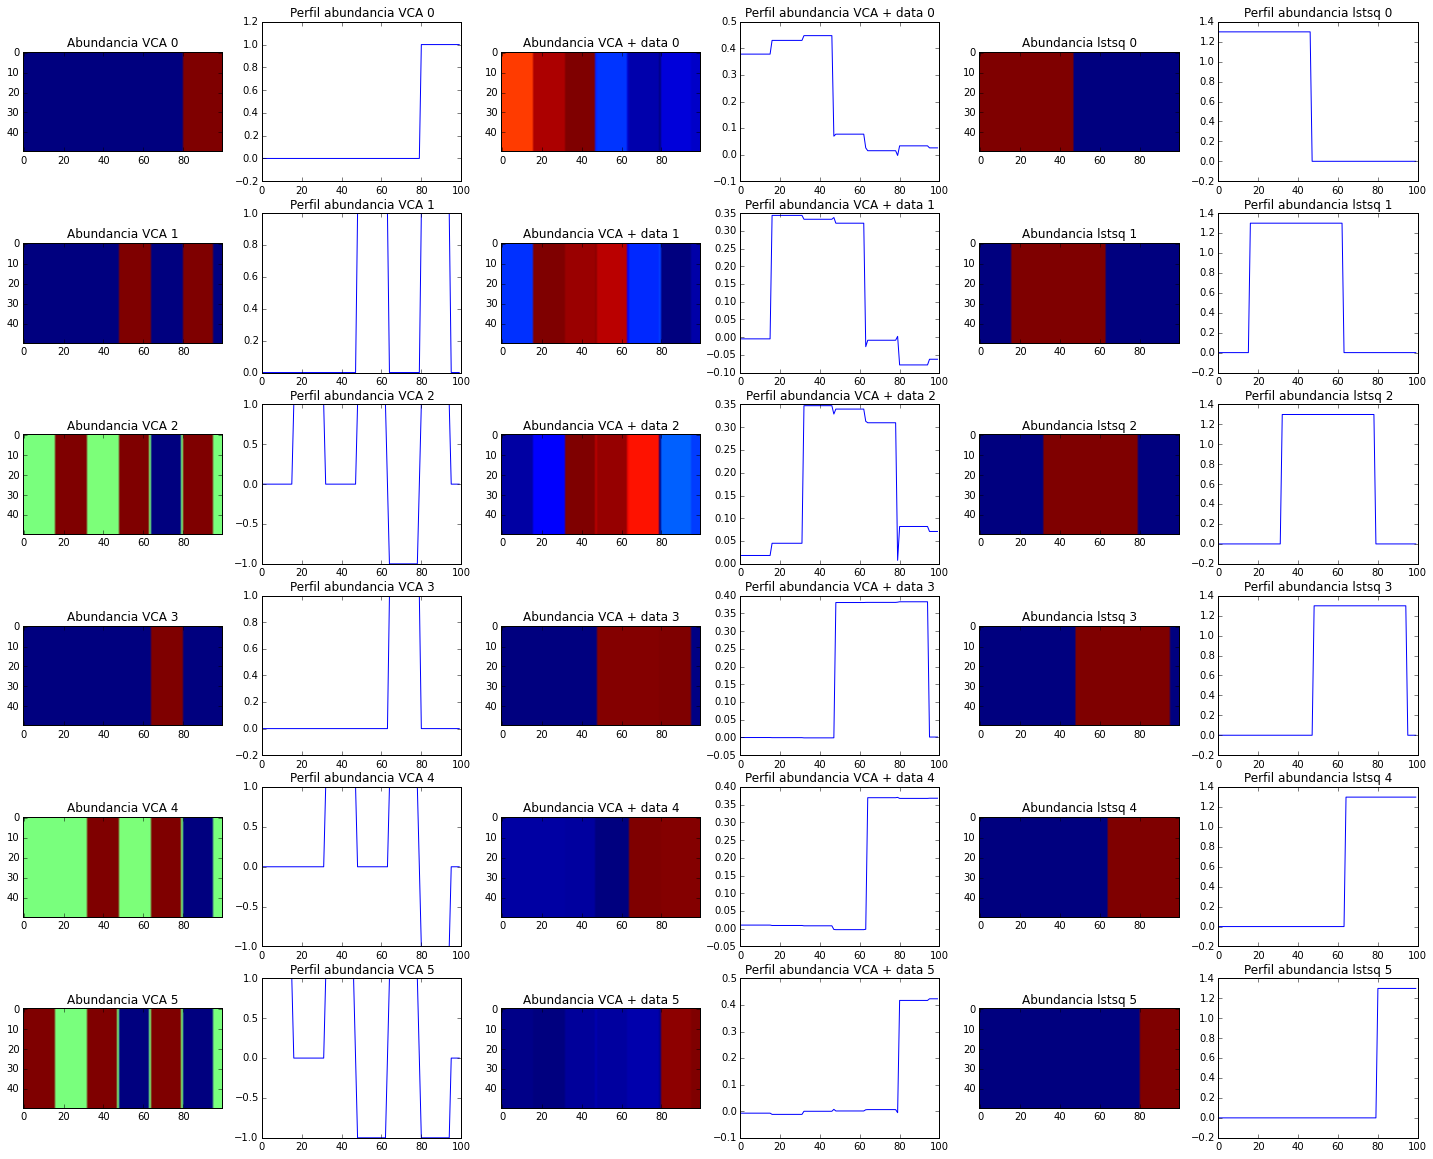

In [87]:

figure, axss = plt.subplots(p,6,figsize=(25,20))
for i in range(p):
    axss[i][0].imshow(S_est[:,:,i])
    axss[i][1].plot(S_est[25,:,i])
    axss[i][2].imshow(S_est_known[:,:,i])
    axss[i][3].plot(S_est_known[25,:,i])
    axss[i][4].imshow(S_est_lstsq[:,:,i])
    axss[i][5].plot(S_est_lstsq[25,:,i])
    axss[i][0].set_title('Abundancia VCA ' + str(i))
    axss[i][1].set_title('Perfil abundancia VCA ' + str(i))
    axss[i][2].set_title('Abundancia VCA + data ' + str(i))
    axss[i][3].set_title('Perfil abundancia VCA + data ' + str(i))
    axss[i][4].set_title('Abundancia lstsq ' + str(i))
    axss[i][5].set_title('Perfil abundancia lstsq ' + str(i))
#plt.savefig('Abundancias_poco_ruido_2espectros.png')  


'''
figure, axss = plt.subplots(p,6,figsize=(25,20))
for i in range(p):
    axss[i][0].imshow(S_est[:,:,i])
    axss[i][1].plot(S_est[25,:,i])
    axss[i][2].imshow(S_est_known[:,:,i])
    axss[i][3].plot(S_est_known[25,:,i])
    axss[i][4].imshow(S_est_lstsq_pca_spectrum[:,:,i])
    axss[i][5].plot(S_est_lstsq_pca_spectrum[25,:,i])
    axss[i][0].set_title('Abundancia VCA ' + str(i))
    axss[i][1].set_title('Perfil abundancia VCA ' + str(i))
    axss[i][2].set_title('Abundancia VCA + data ' + str(i))
    axss[i][3].set_title('Perfil abundancia VCA + data ' + str(i))
    axss[i][4].set_title('Abundancia PCA + lstsq ' + str(i))
    axss[i][5].set_title('Perfil abundancia PCA + lstsq ' + str(i))
#plt.savefig('Abundancias_sol10_6espectros_bis.png')  
'''
'''
figure, axss = plt.subplots(p,5,figsize=(25,20))
for i in range(p):
    axss[i][0].imshow(S_est[:,:,i])
    axss[i][1].plot(S_est[25,:,i])
    axss[i][2].imshow(abundancias_reales[:,:,i])
    axss[i][3].plot(abundancias_reales[25,:,i])
    axss[i][4].plot(wavelengths, data[i](wavelengths))
    axss[i][0].set_title('Abundancia VCA ' + str(i))
    axss[i][1].set_title('Perfil abundancia VCA ' + str(i))
    axss[i][2].set_title('Abundancia real ' + str(i))
    axss[i][3].set_title('Perfil abundancia real ' + str(i))
    axss[i][4].set_title('Espectro endmember ' + str(i))
    #plt.savefig('vca_vs_real_3espectros_parecidos.png')  
    '''

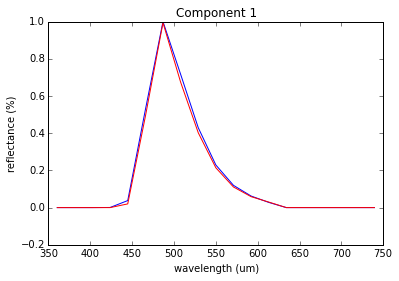

In [78]:
#Espectro original vs. espectro reconstruido

x = np.arange(300,1000)

def plot_firm(i, m):
    plt.plot(wavelengths,A_est[:,i]/np.amax(A_est[:,i]),'b-',
             wavelengths, data[m](wavelengths),'r-')
    plt.title('Component %d'% i)
    plt.xlabel('wavelength (um)')
    plt.ylabel('reflectance (%)')
    plt.show()

interact(plot_firm, i=(0,p-1), m=(0, len(data)-1))

#(0,3)(1,4)(2,5)(3,0)(4,2)(5,1)

In [ ]:
#Espectros originales superpuestos

import matplotlib.patches as mpatches

x = np.arange(450,800)


Atto390 = plt.plot(x, data[0](x),'r-')
Atto633 = plt.plot(x, data[1](x),'b-')
plt.title('Espectro de emision')
plt.xlabel('Longitud de onda (um)')
plt.ylabel('Intensidad')
a390_patch = mpatches.Patch(color='red', label='Atto 390')
a633_patch = mpatches.Patch(color='blue', label='Atto 633')
plt.legend(handles=[a390_patch, a633_patch])
plt.savefig('Emision_Atto390_Atto633')
plt.show()

#plt.legend([line_up, line_down], ['Line Up', 'Line Down'])



In [ ]:
# Abundancias reconstruidas con cuadrados mínimos (a menos que haya ruido, suelen ser iguales al input)

plt.figure()
plt.imshow(S_est_lstsq[:,:,0])
plt.title('Abundancia 1')
plt.colorbar()
#plt.savefig('Abundancia 1.png')
plt.show()

plt.figure()
plt.imshow(S_est_lstsq[:,:,1])
plt.title('Abundancia 2')
plt.colorbar()
#plt.savefig('Abundancia 2.png')
plt.show()

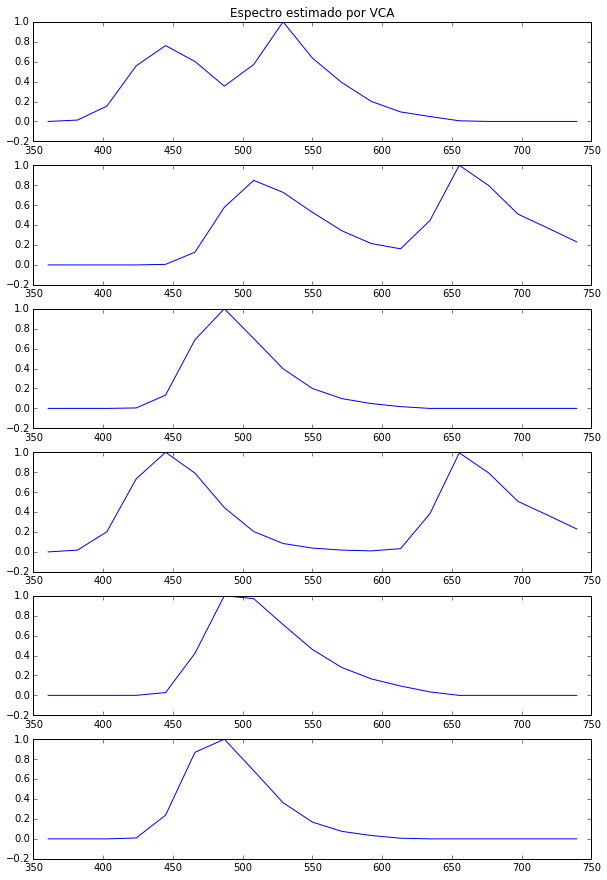

In [88]:
#(0,3)(1,4)(2,5)(3,0)(4,2)(5,1)

figure, axss = plt.subplots(p, sharey=True, figsize=(10,15))
axss[0].plot(wavelengths,A_est[:,0]/np.amax(A_est[:,0]),'b-')#,wavelengths, data[0](wavelengths)/np.amax(data[0](wavelengths)),'r-')
axss[1].plot(wavelengths,A_est[:,1]/np.amax(A_est[:,1]),'b-')#,wavelengths, data[1](wavelengths)/np.amax(data[1](wavelengths)),'r-')
axss[2].plot(wavelengths,A_est[:,2]/np.amax(A_est[:,2]),'b-')#,wavelengths, data[2](wavelengths)/np.amax(data[2](wavelengths)),'r-')
axss[3].plot(wavelengths,A_est[:,3]/np.amax(A_est[:,3]),'b-')#,wavelengths, data[0](wavelengths)/np.amax(data[0](wavelengths)),'r-')
axss[4].plot(wavelengths,A_est[:,4]/np.amax(A_est[:,4]),'b-')#,wavelengths, data[2](wavelengths)/np.amax(data[2](wavelengths)),'r-')
axss[5].plot(wavelengths,A_est[:,5]/np.amax(A_est[:,5]),'b-')#,wavelengths, data[1](wavelengths)/np.amax(data[1](wavelengths)),'r-')
axss[0].set_title('Espectro estimado por VCA')
plt.savefig('espectros_vca_sinpixelpuro.png')

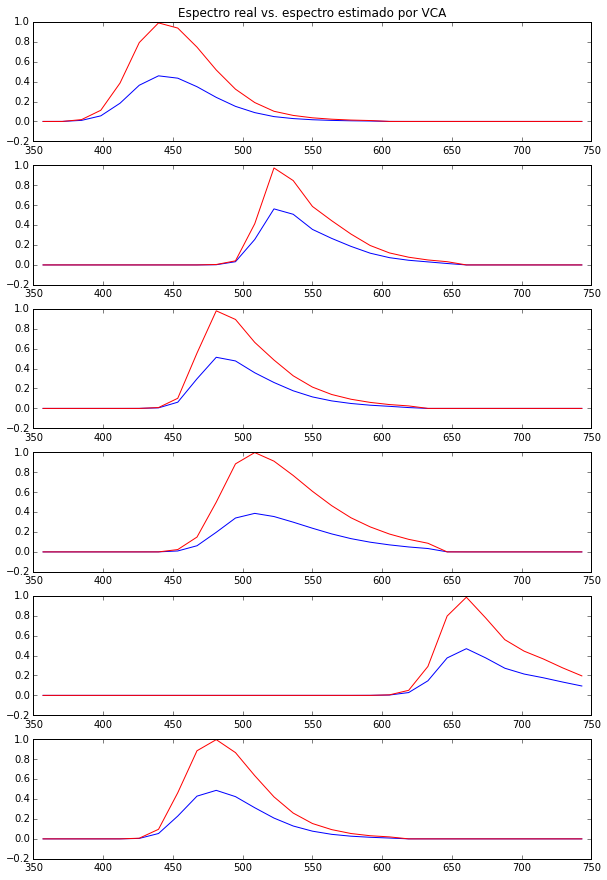

In [66]:
figure, axss = plt.subplots(p, sharey=True, figsize=(10,15))
axss[0].plot(wavelengths,A_est[:,0],'b-',wavelengths, data[4](wavelengths),'r-')
axss[1].plot(wavelengths,A_est[:,1],'b-',wavelengths, data[5](wavelengths),'r-')
axss[2].plot(wavelengths,A_est[:,2],'b-',wavelengths, data[1](wavelengths),'r-')
axss[3].plot(wavelengths,A_est[:,3],'b-',wavelengths, data[2](wavelengths),'r-')
axss[4].plot(wavelengths,A_est[:,4],'b-',wavelengths, data[3](wavelengths),'r-')
axss[5].plot(wavelengths,A_est[:,5],'b-',wavelengths, data[0](wavelengths),'r-')
axss[0].set_title('Espectro real vs. espectro estimado por VCA')
#plt.savefig('superposicion_espectros_30wav_endx1_sinnormalizar.png')

In [ ]:
import itertools

fig, axs = plt.subplots(p, len(data), figsize=(10,10))
for i, m in itertools.product(range(p), range(len(data))):
    axs[i][m].scatter(A_est[:,i], data[m](wavelengths))
    axs[i][m].set_xticks([])
    axs[i][m].set_yticks([])
#plt.savefig('correlacion.png')    

In [ ]:
fig, axs = plt.subplots(p, len(data), figsize=(10,10))
for i, m in itertools.product(range(p), range(len(data))):
    axs[i][m].plot(wavelengths, (A_est[:,i] - data[m](wavelengths)))
    axs[i][m].set_xticks([])
    axs[i][m].set_yticks([])